# Applied Mathematics for Complex Systems Modeling
## Chapter 1: Introduction to Complex Systems Theory
### Section 1.2: Emergence - When the Whole Exceeds the Sum of Its Parts

This notebook contains exercises exploring emergence in complex systems - how simple local interactions lead to surprising global behaviors that cannot be easily predicted from individual components.

## Setup

Let's import the necessary libraries for our exercises:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import scipy.signal as signal
import networkx as nx

# For reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## Exercise 1: Conway's Game of Life (Solved Example)

Conway's Game of Life is a classic example of emergence, where simple cellular automaton rules lead to complex patterns and behaviors. The rules are:

1. A live cell with fewer than 2 live neighbors dies (underpopulation)
2. A live cell with 2 or 3 live neighbors survives
3. A live cell with more than 3 live neighbors dies (overpopulation)
4. A dead cell with exactly 3 live neighbors becomes alive (reproduction)

Let's implement the Game of Life and observe the emergent patterns.

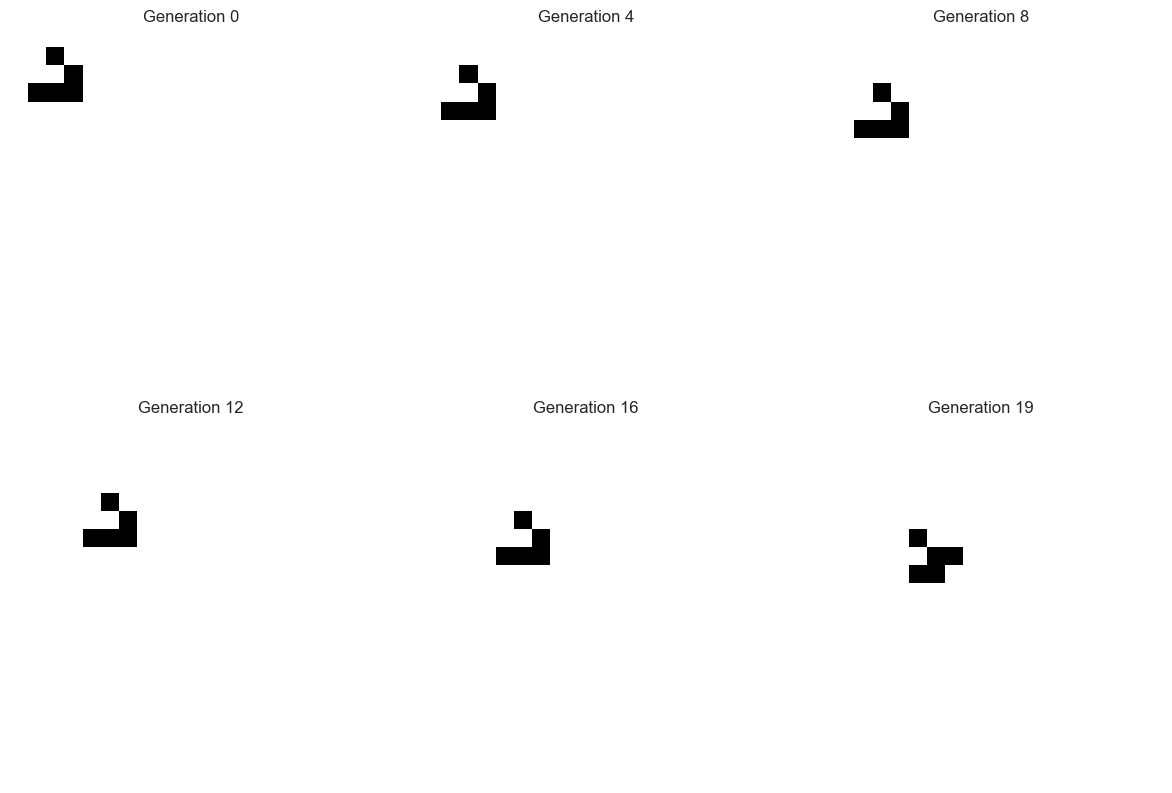

In [2]:
def initialize_grid(size, pattern='random', density=0.3):
    """Initialize a grid of specified size with a pattern.
    
    Parameters:
    -----------
    size : tuple
        Grid dimensions (height, width)
    pattern : str
        'random', 'glider', or 'blinker'
    density : float
        Probability of a cell being alive in random pattern
        
    Returns:
    --------
    grid : 2D numpy array
        Initial grid state
    """
    grid = np.zeros(size, dtype=int)
    
    if pattern == 'random':
        grid = np.random.choice([0, 1], size=size, p=[1-density, density])
    
    elif pattern == 'glider':
        # Place a glider pattern in the top-left corner
        glider = np.array([[0, 1, 0],
                           [0, 0, 1],
                           [1, 1, 1]])
        r, c = 1, 1
        grid[r:r+3, c:c+3] = glider
    
    elif pattern == 'blinker':
        # Place a blinker pattern in the center
        r, c = size[0]//2, size[1]//2
        grid[r, c-1:c+2] = 1
    
    return grid

def update_grid(grid):
    """Update the grid according to Game of Life rules."""
    # Count neighbors using convolution
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    neighbors = signal.convolve2d(grid, kernel, mode='same', boundary='wrap')
    
    # Apply the rules
    new_grid = np.zeros_like(grid)
    new_grid[(grid == 1) & ((neighbors == 2) | (neighbors == 3))] = 1  # Survival
    new_grid[(grid == 0) & (neighbors == 3)] = 1  # Reproduction
    
    return new_grid

def run_game_of_life(initial_grid, generations):
    """Run Game of Life for specified number of generations."""
    grid_history = [initial_grid.copy()]
    grid = initial_grid.copy()
    
    for _ in range(generations):
        grid = update_grid(grid)
        grid_history.append(grid.copy())
    
    return grid_history

# Initialize with a glider pattern
grid_size = (20, 20)
initial_grid = initialize_grid(grid_size, pattern='glider')
generations = 20

# Run the simulation
grid_history = run_game_of_life(initial_grid, generations)

# Create an animation
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(grid_history[0], cmap='binary')
ax.set_title('Generation 0')
ax.set_axis_off()

def update(frame):
    img.set_array(grid_history[frame])
    ax.set_title(f'Generation {frame}')
    return [img]

ani = FuncAnimation(fig, update, frames=len(grid_history), interval=200, blit=True)
plt.close()  # Prevent duplicate display
HTML(ani.to_jshtml())

# Also show some static snapshots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

snapshot_gens = [0, 4, 8, 12, 16, 19]
for i, gen in enumerate(snapshot_gens):
    axes[i].imshow(grid_history[gen], cmap='binary')
    axes[i].set_title(f'Generation {gen}')
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

### Explanation

The Game of Life demonstrates emergence through several key principles:

1. **Local Rules, Global Behavior**: The rules only consider a cell and its immediate neighbors, yet they produce complex global patterns.

2. **Self-Organization**: From random initial conditions, organized structures emerge without central coordination.

3. **Pattern Formation**: The system spontaneously forms recognizable patterns like "gliders," "blinkers," and "still lifes."

4. **Computational Universality**: The Game of Life is Turing complete, meaning it can simulate any computer algorithm despite its simple rules.

This illustrates a fundamental principle of emergence in complex systems: simple, deterministic rules applied locally can generate rich, unpredictable global behavior that cannot be easily derived from examining the rules alone.

## Exercise 2: Boids - Emergent Flocking Behavior

Another classic example of emergence is the Boids model, developed by Craig Reynolds in 1986. It simulates flocking behavior using three simple rules:

1. **Separation**: Avoid crowding nearby flockmates
2. **Alignment**: Steer towards the average heading of nearby flockmates
3. **Cohesion**: Steer towards the average position of nearby flockmates

With just these three rules, the model produces realistic flocking behavior similar to birds or fish schools - a classic example of emergent behavior.

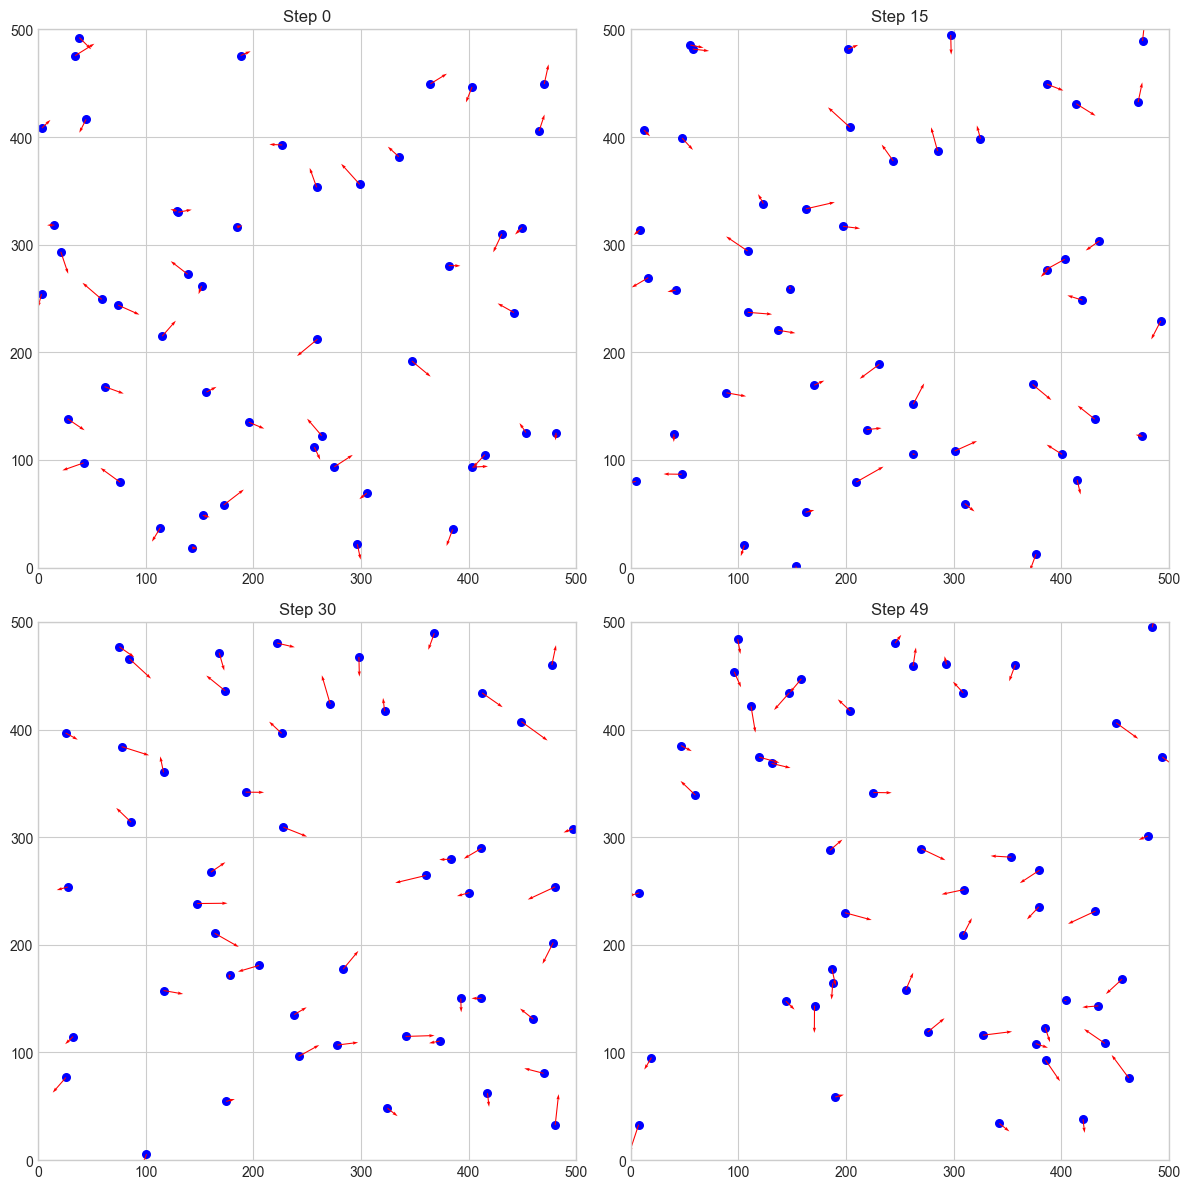

In [3]:
class Boid:
    def __init__(self, x, y, width, height):
        self.position = np.array([x, y], dtype=float)
        self.velocity = np.random.uniform(-1, 1, 2) * 2  # Random initial velocity
        self.acceleration = np.zeros(2, dtype=float)
        self.max_speed = 3.0
        self.max_force = 0.1
        self.perception = 50  # Radius to consider neighbors
        self.width = width
        self.height = height
    
    def apply_behavior(self, boids):
        """Apply the three flocking rules"""
        alignment = self.align(boids)
        cohesion = self.cohesion(boids)
        separation = self.separation(boids)
        
        # Weight the forces
        alignment *= 1.0
        cohesion *= 1.0
        separation *= 1.5  # Separation often needs more weight
        
        # Apply forces
        self.acceleration += alignment
        self.acceleration += cohesion
        self.acceleration += separation
    
    def align(self, boids):
        """Steer towards average heading of local flockmates"""
        steering = np.zeros(2, dtype=float)
        total = 0
        avg_vector = np.zeros(2, dtype=float)
        
        for boid in boids:
            if np.linalg.norm(boid.position - self.position) < self.perception:
                avg_vector += boid.velocity
                total += 1
        
        if total > 0:
            avg_vector /= total
            avg_vector = self.set_magnitude(avg_vector, self.max_speed)
            steering = avg_vector - self.velocity
            steering = self.limit(steering, self.max_force)
        
        return steering
    
    def cohesion(self, boids):
        """Steer towards average position of local flockmates"""
        steering = np.zeros(2, dtype=float)
        total = 0
        center_of_mass = np.zeros(2, dtype=float)
        
        for boid in boids:
            if np.linalg.norm(boid.position - self.position) < self.perception:
                center_of_mass += boid.position
                total += 1
        
        if total > 0:
            center_of_mass /= total
            vec_to_com = center_of_mass - self.position
            if np.linalg.norm(vec_to_com) > 0:
                vec_to_com = self.set_magnitude(vec_to_com, self.max_speed)
            steering = vec_to_com - self.velocity
            steering = self.limit(steering, self.max_force)
        
        return steering
    
    def separation(self, boids):
        """Steer to avoid crowding local flockmates"""
        steering = np.zeros(2, dtype=float)
        total = 0
        
        for boid in boids:
            distance = np.linalg.norm(boid.position - self.position)
            if boid != self and distance < self.perception:
                diff = self.position - boid.position
                diff = diff / (distance * distance)  # Weight by inverse square of distance
                steering += diff
                total += 1
        
        if total > 0:
            steering /= total
            if np.linalg.norm(steering) > 0:
                steering = self.set_magnitude(steering, self.max_speed)
            steering = steering - self.velocity
            steering = self.limit(steering, self.max_force)
        
        return steering
    
    def update(self):
        """Update position and velocity"""
        self.velocity += self.acceleration
        self.velocity = self.limit(self.velocity, self.max_speed)
        self.position += self.velocity
        self.acceleration = np.zeros(2, dtype=float)
        
        # Wrap around boundaries
        self.position[0] = self.position[0] % self.width
        self.position[1] = self.position[1] % self.height
    
    def set_magnitude(self, vector, mag):
        """Set the magnitude of a vector"""
        if np.linalg.norm(vector) == 0:
            return vector
        return vector * (mag / np.linalg.norm(vector))
    
    def limit(self, vector, max_val):
        """Limit the magnitude of a vector"""
        if np.linalg.norm(vector) > max_val:
            return self.set_magnitude(vector, max_val)
        return vector

# Let's run a simplified simulation and create a visualization
def simulate_boids(n_boids=50, width=500, height=500, steps=100):
    """Simulate a flock of boids"""
    boids = [Boid(np.random.uniform(0, width), np.random.uniform(0, height), width, height) for _ in range(n_boids)]
    
    # Store positions for animation
    positions = np.zeros((steps, n_boids, 2))
    velocities = np.zeros((steps, n_boids, 2))
    
    for step in range(steps):
        for i, boid in enumerate(boids):
            boid.apply_behavior(boids)
            boid.update()
            positions[step, i] = boid.position
            velocities[step, i] = boid.velocity
    
    return positions, velocities

# Run the simulation
n_boids = 50
width, height = 500, 500
steps = 50

positions, velocities = simulate_boids(n_boids, width, height, steps)

# Create an animation
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.set_aspect('equal')
ax.set_title('Boids Flocking Simulation')

scatter = ax.scatter(positions[0, :, 0], positions[0, :, 1], c='blue', s=30)

# Add velocity arrows (quiver plot)
quiver = ax.quiver(positions[0, :, 0], positions[0, :, 1],
                   velocities[0, :, 0], velocities[0, :, 1],
                   scale=50, width=0.002, color='red')

def update_anim(frame):
    scatter.set_offsets(positions[frame])
    quiver.set_offsets(positions[frame])
    quiver.set_UVC(velocities[frame, :, 0], velocities[frame, :, 1])
    return scatter, quiver

ani = FuncAnimation(fig, update_anim, frames=steps, interval=100, blit=True)
plt.close()  # Prevent duplicate display
HTML(ani.to_jshtml())

# Also show some static snapshots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

snapshot_steps = [0, 15, 30, 49]
for i, step in enumerate(snapshot_steps):
    axes[i].scatter(positions[step, :, 0], positions[step, :, 1], c='blue', s=30)
    axes[i].quiver(positions[step, :, 0], positions[step, :, 1],
                  velocities[step, :, 0], velocities[step, :, 1],
                  scale=50, width=0.002, color='red')
    axes[i].set_xlim(0, width)
    axes[i].set_ylim(0, height)
    axes[i].set_title(f'Step {step}')
    axes[i].set_aspect('equal')

plt.tight_layout()
plt.show()

### Your Turn: Analyzing Emergent Properties in Boids

Now that we've implemented the Boids model, let's analyze the emergent properties that arise from these simple rules. Complete the exercises below to gain a deeper understanding of emergence in this system.

In [4]:
def calculate_metrics(positions, velocities):
    """Calculate various metrics to quantify emergent behavior in the flock.
    
    Parameters:
    -----------
    positions : array, shape (steps, n_boids, 2)
        Positions of all boids at each time step
    velocities : array, shape (steps, n_boids, 2)
        Velocities of all boids at each time step
        
    Returns:
    --------
    metrics : dict
        Dictionary containing various metrics over time
    """
    steps, n_boids, _ = positions.shape
    
    # TODO: Implement metrics to quantify emergent behavior
    # Some suggestions:
    # 1. Average distance between boids (measure of cohesion)
    # 2. Velocity alignment (measure of alignment)
    # 3. Polarization (how aligned the flock is moving in a particular direction)
    # 4. Angular momentum (measure of milling/rotation behavior)
    
    # Your code here
    
    return metrics

# Test your implementation
# metrics = calculate_metrics(positions, velocities)

# Plot the metrics over time
# fig, ax = plt.subplots(figsize=(10, 6))
# ...
# plt.show()

## Exercise 3: Schelling's Segregation Model

Schelling's segregation model is a classic example of how individual preferences can lead to emergent social patterns. In this model, agents of two different types (e.g., represented by two colors) are placed on a grid. Each agent has a preference for having some percentage of neighbors of the same type. If this preference is not met, the agent moves to a random empty location.

What's striking about this model is that even a mild preference for similar neighbors (e.g., 30%) can lead to significant segregation patterns.

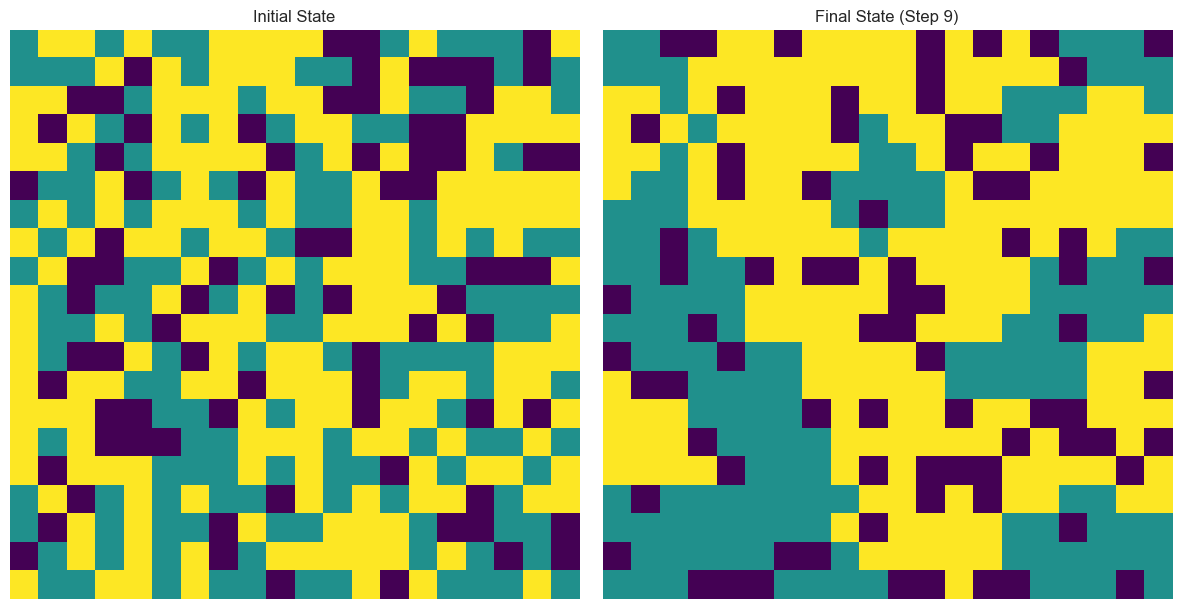

In [5]:
def initialize_schelling(grid_size, empty_ratio, n_types, preference):
    """Initialize a Schelling segregation model.
    
    Parameters:
    -----------
    grid_size : int
        Size of the grid (grid_size x grid_size)
    empty_ratio : float
        Ratio of empty cells
    n_types : int
        Number of different agent types
    preference : float
        Minimum ratio of similar neighbors preferred
        
    Returns:
    --------
    grid : 2D array
        Initial grid state
    agents : list of tuples
        List of agent positions (row, col, type)
    preference : float
        Preference parameter
    """
    # Create grid
    grid = np.zeros((grid_size, grid_size), dtype=int)
    
    # Randomly distribute agents
    n_empty = int(grid_size * grid_size * empty_ratio)
    n_agents = grid_size * grid_size - n_empty
    
    agent_types = np.random.choice(np.arange(1, n_types+1), size=n_agents)
    empty_indices = np.random.choice(grid_size * grid_size, size=n_agents, replace=False)
    
    agent_positions = [(pos // grid_size, pos % grid_size) for pos in empty_indices]
    
    agents = []
    for (row, col), agent_type in zip(agent_positions, agent_types):
        grid[row, col] = agent_type
        agents.append((row, col, agent_type))
    
    return grid, agents, preference

def get_neighbors(grid, row, col):
    """Get the values of the neighbors of a cell."""
    neighbors = []
    for i in range(max(0, row-1), min(grid.shape[0], row+2)):
        for j in range(max(0, col-1), min(grid.shape[1], col+2)):
            if (i, j) != (row, col):  # Skip the cell itself
                neighbors.append(grid[i, j])
    return neighbors

def is_unhappy(grid, row, col, preference):
    """Check if an agent is unhappy with its current location."""
    agent_type = grid[row, col]
    if agent_type == 0:  # Empty cell
        return False
    
    neighbors = get_neighbors(grid, row, col)
    if not neighbors:  # No neighbors
        return False
    
    # Count similar neighbors
    same_type = sum(1 for n in neighbors if n == agent_type)
    other_type = sum(1 for n in neighbors if n != 0 and n != agent_type)
    
    if same_type + other_type == 0:  # No non-empty neighbors
        return False
    
    # Calculate ratio of similar neighbors
    similarity_ratio = same_type / (same_type + other_type)
    
    return similarity_ratio < preference

def update_schelling(grid, agents, preference, max_steps=100):
    """Update the Schelling model for a number of steps."""
    grid_size = grid.shape[0]
    grid_history = [grid.copy()]
    
    for step in range(max_steps):
        # Shuffle agents to avoid bias
        np.random.shuffle(agents)
        
        # Track if any agent moves
        moved = False
        
        for i, (row, col, agent_type) in enumerate(agents):
            if is_unhappy(grid, row, col, preference):
                # Find empty cells
                empty_cells = [(r, c) for r in range(grid_size) for c in range(grid_size) if grid[r, c] == 0]
                
                if empty_cells:  # If there are empty cells
                    # Move to a random empty cell
                    new_row, new_col = empty_cells[np.random.choice(len(empty_cells))]
                    
                    # Update grid
                    grid[row, col] = 0
                    grid[new_row, new_col] = agent_type
                    
                    # Update agent position
                    agents[i] = (new_row, new_col, agent_type)
                    moved = True
        
        grid_history.append(grid.copy())
        
        # If no agent moved, the system has reached equilibrium
        if not moved:
            break
    
    return grid_history

    # Initialize the model
grid_size = 20
empty_ratio = 0.2
n_types = 2
preference = 0.3  # Agents want at least 30% similar neighbors

grid, agents, preference = initialize_schelling(grid_size, empty_ratio, n_types, preference)
grid_history = update_schelling(grid, agents, preference, max_steps=50)

# Visualize the evolution
fig, ax = plt.subplots(figsize=(8, 8))
cmap = plt.cm.get_cmap('viridis', n_types+1)
im = ax.imshow(grid_history[0], cmap=cmap, vmin=0, vmax=n_types)
ax.set_title('Step 0')
ax.set_axis_off()

def update_anim(frame):
    im.set_array(grid_history[frame])
    ax.set_title(f'Step {frame}')
    return [im]

ani = FuncAnimation(fig, update_anim, frames=len(grid_history), interval=200, blit=True)
plt.close()  # Prevent duplicate display
HTML(ani.to_jshtml())

# Show initial and final states
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(grid_history[0], cmap=cmap, vmin=0, vmax=n_types)
ax1.set_title('Initial State')
ax1.set_axis_off()

ax2.imshow(grid_history[-1], cmap=cmap, vmin=0, vmax=n_types)
ax2.set_title(f'Final State (Step {len(grid_history)-1})')
ax2.set_axis_off()

plt.tight_layout()
plt.show()